In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import datetime
from datetime import timedelta
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from platform import python_version
# import bokeh
# from bokeh.io import output_notebook
# from bokeh.plotting import figure, show
# from bokeh.models import HoverTool

In [3]:
print("Henri is using Python version 3.6.8.  You are using Python version {}.".format(python_version()))
print("Henri is using numpy version 1.15.4.  You are using numpy version {}.".format(np.__version__))
print("Henri is using pandas version 0.24.0.  You are using pandas version {}.".format(pd.__version__))
print("Henri is using matplotlib version 2.2.3.  You are using matplotlib version {}.".format(matplotlib.__version__))

Henri is using Python version 3.6.8.  You are using Python version 3.6.8.
Henri is using numpy version 1.15.4.  You are using numpy version 1.15.4.
Henri is using pandas version 0.24.0.  You are using pandas version 0.24.0.
Henri is using matplotlib version 2.2.3.  You are using matplotlib version 2.2.3.


# Specify the Probe-ID you are interested in:

Valid options are:
* `"P-370"`
* `"P-371"`
* `"P-372"`
* `"P-384"`
* `"P-391"`
* `"P-392"`
* `"P-891"`

You can change the Probe-ID in the following code-cell, and please remember to specify it in string format:

In [4]:
probe_id = "P-371"
assert isinstance(probe_id, str), "variable probe_id must be of type string!"

# Define a helper function called `"flagger"`

This `"flagger"` function will set the flag value equal to 1 for faulty data.  The dates for which the flag value is equal to 1 will not be used in the new calculation of $k_{cp} = \frac{ET_{cp}}{ET_o}$.

`"flagger"` will also add a description in the `"description"` column about why a particular date has been flagged.

The `"flagger"` function only operates on the `"df_flag"` DataFrame (instantiated later in this notebook) which only has two columns:
1. `"binary_value"`
2. `"description"`  
`"df_flag"` also has a DateTime Index.

Later on, if desired, we can then merge the `"df_flag"` DataFrame with the main DataFrame containing all our data.  Our merging will take place in such a fashion that we merge entries corresponding to identical dates. (In short, we merge on the Index of our DataFrame).

In [5]:
def flagger(bad_dates, brief_desc):
    """
    Flag bad_dates with a binary value of 1 and append a brief description about why bad_dates were flagged.
    
    Parameters:
    bad_dates (pandas.core.indexes.datetimes.DatetimeIndex):  Dates for which we cannot calculate k_cp because our readings were perturbed and rendered unuseful.
    brief_desc (str):  A very short description about why bad_dates were flagged.
    
    Returns:
    None.  It updates the DataFrame storing all the information related to flagging.  In this case the DataFrame is called `df_flag`    
    """
    if df_flag.loc[bad_dates, "description"].str.contains(brief_desc).all(axis=0):
        # The bad_dates have already been flagged for the reason given in brief_desc.
        # No use in duplicating brief_desc contents in the description column.
        # Therefore redundant information in the df_flag DataFrame is avoided.
        print("You have already flagged these dates for the reason given in `brief_desc`; No flagging has taken place.")
        return
    else:
        df_flag.loc[bad_dates, "binary_value"] = 1
        df_flag.loc[bad_dates, "description"] += (" " + brief_desc + ".")
        df_flag.loc[:, "description"] = df_flag.loc[:, "description"].apply(lambda s: s.lstrip().rstrip())

# Define a helper function named `reporter`:

This function prints statements regarding:
1. How much data was lost due to a specific flagging operation.
2. How much data remains useful after all the flagging that has taken place in the entire notebook session.

In [35]:
def reporter(brief_desc, remaining=False):
    tally = df_flag["description"].str.contains(brief_desc).sum()
    n_tot_entries = len(df_flag.index)
    perc = tally / n_tot_entries * 100
    print("{:.1f}% of data is lost due to [{}].".format(perc, brief_desc))
    
    if remaining:
        calc = 100 - df_flag["binary_value"].sum()/len(df_flag.index)*100
        print("\nAfter all the flagging that has taken place in this entire notebook, only {:.0f}% of your data is useful.".format(calc))

# Extract the data from our Excel file and store it in a `pandas` DataFrame.

- Notice in the following code cell, we extract the daily data for the probe of interest.

- In the for-loop, we remove the unnecessary leading white-space at the beginning of each column name.  After the redundant white-space has been removed, we assign the redundant-free column names to the dataframe.

In [6]:
data = pd.read_excel("Golden_Delicious_daily_data.xlsx", sheet_name=probe_id, index_col=0, parse_dates=True)
new_columns = []
for c in data.columns:
    new_columns.append(c.lstrip())
data.columns = new_columns
print(data.columns)

Index(['heat_units', 'rain', 'erain', 'total_irrig', 'tot_eff_irrig', 'etc',
       'ety', 'et0', 'etcp', 'rzone', 'available', 'days_left',
       'deficit_current', 'rzm', 'rzm_source', 'fcap', 'profile',
       'deficit_want', 'refill', 'et0_forecast_yr', 'original_unit_system'],
      dtype='object')


In the following code we create a standalone dataframe which will store flag values as well as descriptions on why a particular date was flagged as being inappropriate for our new calculation of $k_{cp}$.  At first, we initialise all our dates to a flag value of 0.  If during our analysis we realise that there are dates with junk data, we will update the flag value to be 1, and also provide a brief description.

In [7]:
df_flag = pd.DataFrame(index=data.index, columns=["binary_value", "description"])
df_flag["binary_value"] = 0
df_flag["description"] = str()  # we initialise this column with an empty string `""`
df_flag.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 2 columns):
binary_value    550 non-null int64
description     550 non-null object
dtypes: int64(1), object(1)
memory usage: 12.9+ KB


The following data columns are not of interest to us for our analysis:
* `rzone`
* `available`
* `days_left`
* `deficit_current`
* `rzm`
* `fcap`
* `deficit_want`
* `refill`
* `et0_forecast_yr`

Therefore, I am going to drop these columns from the `data` DataFrame:

In [8]:
data.drop(labels=["rzone", "available", "days_left", "deficit_current", "rzm", 
                  "fcap", "deficit_want", "refill", "et0_forecast_yr"], axis=1, inplace=True)

In [9]:
data.head()

,heat_units,rain,erain,total_irrig,tot_eff_irrig,etc,ety,et0,etcp,rzm_source,profile,original_unit_system
date,,,,,,,,,,,,
2017-08-01,0.0,0.0,0.0,0.0,0.0,0.82,0.68,6.8,120.37,Electronic Probe,120.37,si
2017-08-02,0.0,1.0,0.0,0.0,0.0,0.49,0.68,6.8,1.32,Electronic Probe,121.69,si
2017-08-03,0.0,0.2,0.0,0.0,0.0,0.49,0.68,6.8,0.50,Electronic Probe,122.19,si
2017-08-04,0.0,0.0,0.0,0.0,0.0,0.49,0.68,6.8,0.71,Electronic Probe,122.91,si
2017-08-05,0.0,0.0,0.0,0.0,0.0,0.49,0.68,6.8,0.10,Electronic Probe,123.01,si


# `"rain"` versus time

At this point I am not entirely sure how to flag `"rain"` data?

In [10]:
# df_rain = data.filter(["rain"], axis=1)
# df_rain.head()

In [11]:
# fig, ax = plt.subplots()
# fig.set_size_inches(8, 3)

# ax.bar(x=df_rain.index, height=df_rain["rain"])
# ax.set_xlabel("Date")
# ax.set_ylabel("Rain [mm]")
# ax.set_title("Rain versus time")

### Flagging rain events

We want to flag dates for which the rain exceeds 2mm.

In [12]:
# condition = df_rain["rain"] > 2.0
# flag_rain_dates = df_rain[condition].index

# flagger(flag_rain_dates, "Rain above 2mm")

In [13]:
# print(df_flag["binary_value"].sum())

# Investigate `"rzm_source"`:  "`software`" versus "`Electronic Probe`".

Basically we want to flag the entries for which the column `"rzm_source"` contains the description `software`.

In [14]:
condition = data["rzm_source"].str.contains("software")
flag_software_dates = data[condition].index

flagger(flag_software_dates, "Software simulation")

In [32]:
reporter(brief_desc="Software simulation")

5% of data is lost due to [Software simulation].


# `"Total Irrigation"`

At this stage I am hesitant to set flag values for Irrigation dates, mainly because it is possible that a farmer **logged an Irrigation event on the wrong date**.

In [16]:
df_irr = data.filter(["total_irrig"], axis=1)
df_irr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
total_irrig    550 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB


One suggestion on accurately flagging the irrigation events is as follows:  
Flag a data entry:
1. If the farmer logged irrigation taking place for that day, **AND**
2. If the cerresponding $ET_{cp} > 0$, **AND**
3. If there is no rain for that particular day.

Let us implement this in the following code cell:

In [20]:
conditions = (data["total_irrig"] > 0) & (data["etcp"] > 0) & (data["rain"] == 0)
flag_irrigation_dates = data[conditions].index
print(conditions.sum())

flagger(bad_dates=flag_irrigation_dates, brief_desc="Irrigation perturbing etcp")

39
You have already flagged these dates for the reason given in `brief_desc`; No flagging has taken place.


In [33]:
reporter(brief_desc="Irrigation perturbing etcp")

7% of data is lost due to [Irrigation perturbing etcp].


<IPython.core.display.Javascript object>


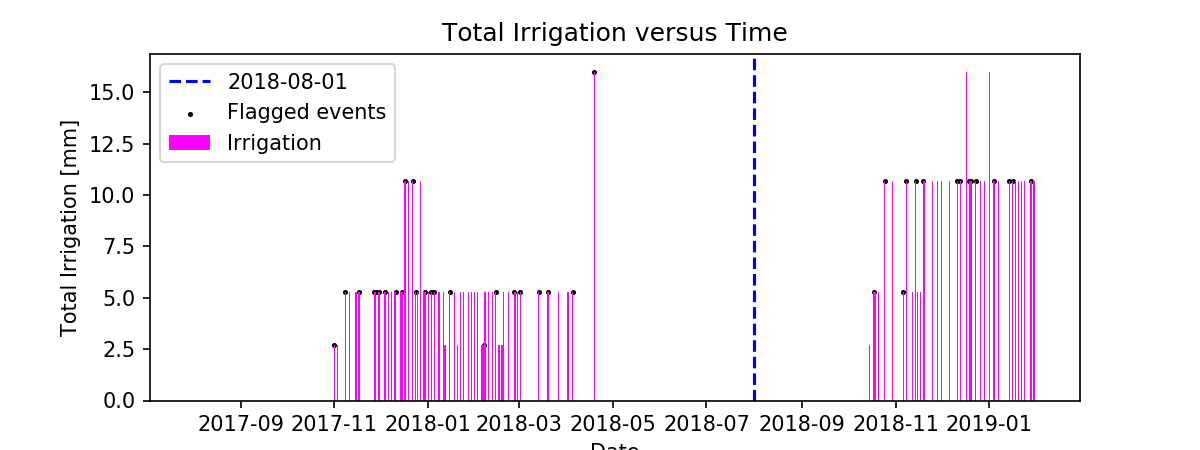

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.bar(df_irr.index, df_irr["total_irrig"], color="magenta", label="Irrigation")
ax.scatter(flag_irrigation_dates, df_irr.loc[flag_irrigation_dates, ["total_irrig"]], label="Flagged events", 
           c="black", marker="o", s=2)
ax.set_xlabel("Date")
ax.set_ylabel("Total Irrigation [mm]")
ax.set_title("Total Irrigation versus Time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", ls="--", label="2018-08-01")
ax.legend()
plt.show()

# `"profile"` versus time

Notice that `"profile"` corresponds to column R in the Excel spreadsheet.

In [39]:
df_profile = data.filter(["profile"], axis=1)
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
profile    550 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB


In [40]:
df_profile.describe()

,profile
count,550.000000
mean,197.624673
std,61.125137
min,0.000000
25%,165.637500
50%,215.610000
75%,233.767500
max,349.510000


In the `"profile"` column, there are certain entries containing 0.0.  These entries correspond to missing data.

For the missing `"profile"` entries, we replace the 0's with `NaN`s.

In [41]:
df_profile["profile"].replace(0.0, np.nan, inplace=True)  # replace missing entries with NaN
df_profile.info()
df_profile.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
profile    525 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB


,profile
count,525.000000
mean,207.035371
std,44.299823
min,93.540000
25%,171.600000
50%,216.930000
75%,235.620000
max,349.510000


In [42]:
df_profile["difference"] = df_profile["profile"].diff()

huge_dip_days = []
day = datetime.timedelta(days=1)
for d in df_profile.index:
    try:
        if (df_profile.loc[d, "difference"] < 0) and pd.isnull(df_profile.loc[d + day, "profile"]):
            huge_dip_days.append(d)
    except KeyError:
        pass

huge_dip_days = pd.to_datetime(huge_dip_days)
flagger(bad_dates=huge_dip_days, brief_desc="Unrealistic dip in profile")

In [43]:
reporter(brief_desc="Unrealistic dip in profile")

1.6% of data is lost due to [Unrealistic dip in profile].


In [44]:
dummy = pd.DataFrame(index=huge_dip_days, copy=True, columns=["Marker"])
dummy["Marker"] = df_profile.loc[dummy.index, "profile"]
dummy

,Marker
2017-09-01,93.54
2017-10-23,118.03
2017-11-15,129.47
2018-04-25,144.90
2018-06-06,148.90
2018-08-08,157.90
2018-11-28,196.93
2018-12-14,177.61
2019-01-29,276.42


<IPython.core.display.Javascript object>


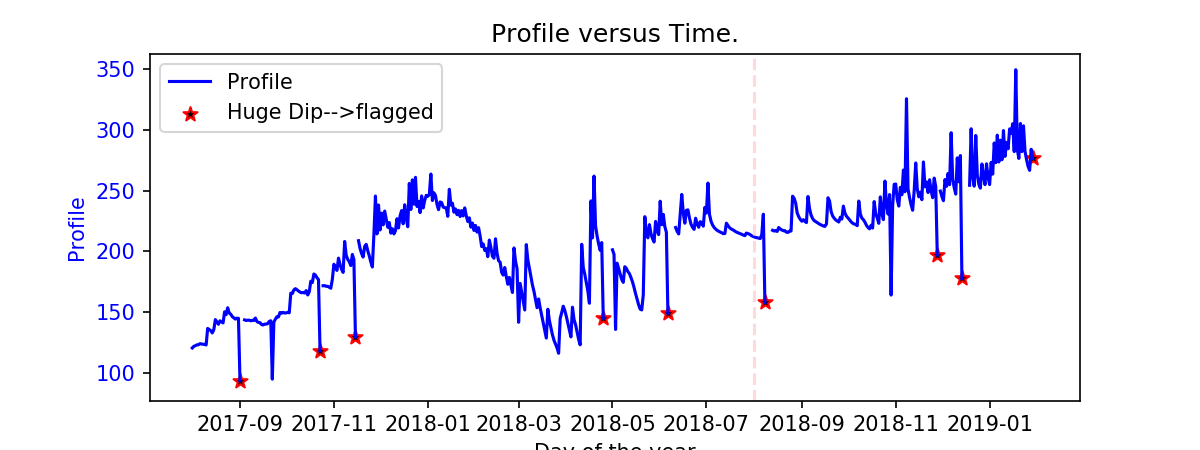

In [45]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8, 3)

color = "blue"
ax1.set_xlabel('Day of the year')
ax1.set_ylabel('Profile', color=color)
ax1.set_title("Profile versus Time.")
ax1.plot(df_profile.index, df_profile["profile"], color=color, label="Profile")
ax1.scatter(x=dummy.index, y=dummy["Marker"], s=50, color="black", 
            marker="*", label="Huge Dip-->flagged", edgecolors="red")
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=datetime.datetime(2018, 8, 1), color="pink", alpha=0.6, linestyle="--")
ax1.legend()

plt.show()

In [46]:
condition = df_profile["profile"].isnull()
bad_profile_days = df_profile[condition].index

flagger(bad_dates=bad_profile_days, brief_desc="Null profile value")

In [47]:
reporter(brief_desc="Null profile value")

4.5% of data is lost due to [Null profile value].


In [75]:
df_profile.loc[huge_dip_days ,["difference"]] = np.nan

negative_differences = df_profile[df_profile["difference"] < 0]["difference"].values
one_percent_percentile = np.quantile(negative_differences, q=[0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])[1]

condition = df_profile["difference"] < one_percent_percentile
print(condition.sum())
large_dip_dates = df_profile[condition].index

6


<IPython.core.display.Javascript object>


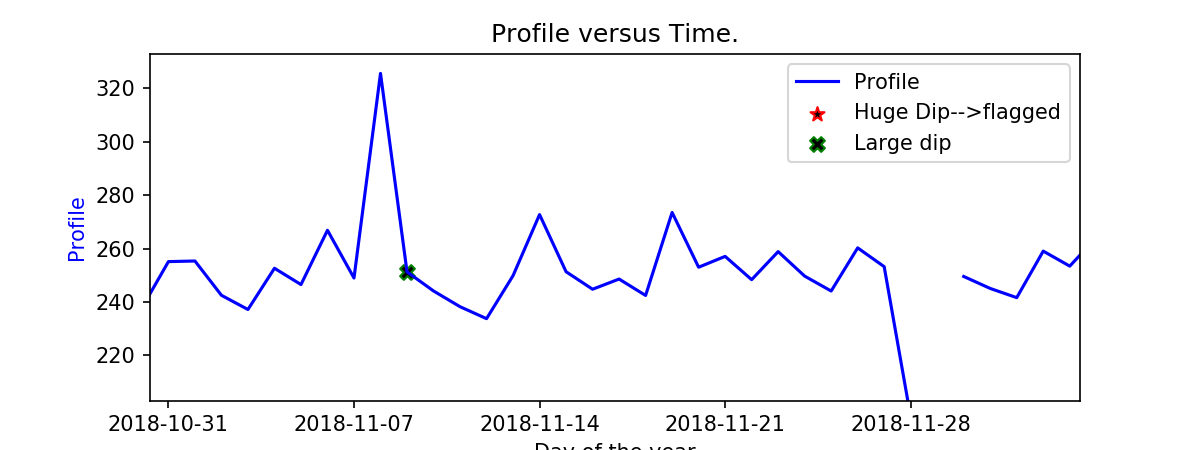

In [76]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8, 3)

color = "blue"
ax1.set_xlabel('Day of the year')
ax1.set_ylabel('Profile', color=color)
ax1.set_title("Profile versus Time.")
ax1.plot(df_profile.index, df_profile["profile"], color=color, label="Profile")
ax1.scatter(x=dummy.index, y=dummy["Marker"], s=50, color="black", 
            marker="*", label="Huge Dip-->flagged", edgecolors="red")
ax1.scatter(x=large_dip_dates, y=df_profile.loc[large_dip_dates, ["profile"]], s=50, color="black", 
            marker="X", label="Large dip", edgecolors="green")
ax1.axvline(x=datetime.datetime(2018, 8, 1), color="pink", alpha=0.6, linestyle="--")
ax1.legend()

plt.show()

### Comments on the `"profile"` time series.

1. The gaps in the graph correspond to NaN entries.
2. Values preceding the NaN entries have a spurious downward trend/dip towards the horizontal axis.

# `"heat_units"` versus Time

Notice that heat_units corresponds to column B of the excile spreadsheet.

In [28]:
df_gdd = data.filter(["heat_units"], axis=1)
print(df_gdd.info())
print("-"*30)
print(df_gdd.head())
print("-"*30)
print(df_gdd.describe())
print("-"*30)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
heat_units    550 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB
None
------------------------------
            heat_units
date                  
2017-08-01         0.0
2017-08-02         0.0
2017-08-03         0.0
2017-08-04         0.0
2017-08-05         0.0
------------------------------
       heat_units
count  550.000000
mean     6.127273
std      4.208461
min      0.000000
25%      2.500000
50%      7.400000
75%      8.950000
max     17.650001
------------------------------


In [29]:
df_gdd["hu_diff1"] = df_gdd["heat_units"].diff(periods=1)
df_gdd["hu_diff2"] = df_gdd["heat_units"].diff(periods=2)
condition = ((df_gdd["hu_diff1"] == 0.0) | (df_gdd["hu_diff2"] == 0))  # bitwise OR operation
bad_hu_days = df_gdd[condition].index

flagger(bad_dates=bad_hu_days, brief_desc="Heat Units `stuck`")

In [30]:
df_gdd.loc[bad_hu_days, "heat_units"] = 0.0

In [31]:
def cumulative(s):
    new = s.to_frame()
    new["cumulative"] = 0.0
    DAY = datetime.timedelta(days=1)
    for stamp in new.index:
        if (stamp.month == 8) and (stamp.day == 1):
            new.loc[stamp, ["cumulative"]] = 0.0
        elif (stamp.month == 8) and (stamp.day == 2):
            new.loc[stamp, ["cumulative"]] = 0.0 + new.loc[stamp]["heat_units"]
        else:
            new.loc[stamp, ["cumulative"]] = new.loc[(stamp - DAY)]["cumulative"] + new.loc[stamp]["heat_units"]
    return new["cumulative"]


df_gdd["cumul_heat_units"] = cumulative(df_gdd["heat_units"])
# df_gdd.head(n=30)

<IPython.core.display.Javascript object>


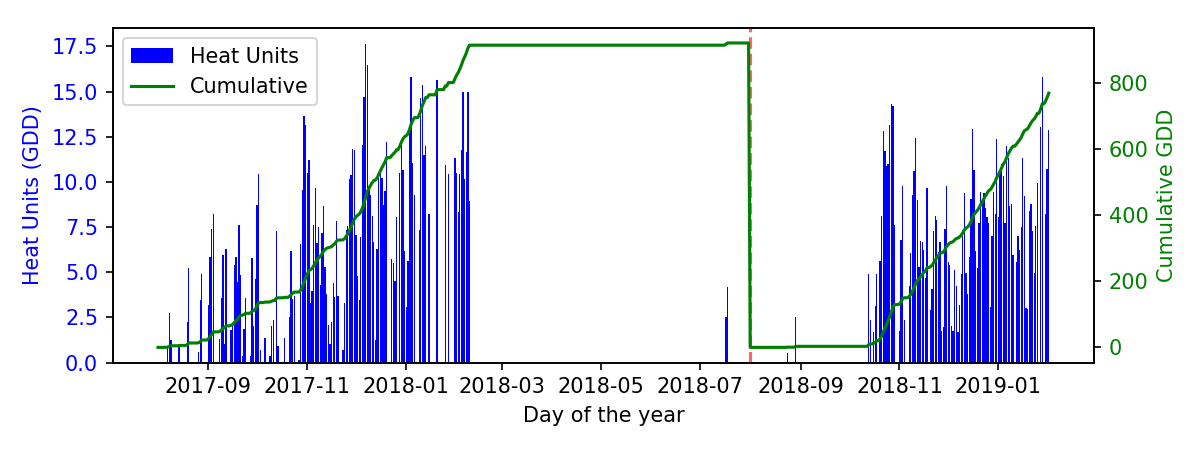

In [32]:
fig = plt.figure()
fig.set_size_inches(8, 3)
ax1 = fig.add_subplot(111)

color = "blue"
ax1.set_xlabel('Day of the year')
ax1.set_ylabel('Heat Units (GDD)', color=color)
pl1 = ax1.bar(df_gdd.index, df_gdd["heat_units"], color=color, label="Heat Units")
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=datetime.datetime(2018, 8 , 1), color="red", ls="--", alpha=0.6)

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
color="green"
ax2.set_ylabel("Cumulative GDD", color=color)
pl2 = ax2.plot(df_gdd.index, df_gdd["cumul_heat_units"], color=color, label="Cumulative")
ax2.tick_params(axis="y", labelcolor=color)

# added these three lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

fig.tight_layout()
plt.show()

In [33]:
df_gdd["heat_units"]

date
2017-08-01     0.000000
2017-08-02     0.000000
2017-08-03     0.000000
2017-08-04     0.000000
2017-08-05     0.000000
2017-08-06     0.000000
2017-08-07     0.800000
2017-08-08     2.750000
2017-08-09     1.250000
2017-08-10     0.000000
2017-08-11     0.000000
2017-08-12     0.000000
2017-08-13     0.000000
2017-08-14     0.950000
2017-08-15     0.000000
2017-08-16     0.000000
2017-08-17     0.000000
2017-08-18     0.000000
2017-08-19     2.250000
2017-08-20     5.250000
2017-08-21     0.000000
2017-08-22     0.000000
2017-08-23     0.000000
2017-08-24     0.000000
2017-08-25     0.000000
2017-08-26     0.600000
2017-08-27     3.450000
2017-08-28     4.900000
2017-08-29     0.000000
2017-08-30     0.000000
                ...    
2019-01-03    11.000000
2019-01-04    10.300000
2019-01-05     7.750000
2019-01-06    12.000000
2019-01-07    11.300000
2019-01-08     8.650000
2019-01-09     8.750000
2019-01-10     5.950000
2019-01-11     0.000000
2019-01-12     5.550000
2019-01-13 

# `["etc", "et0", "etcp"]` versus time

Notice that `"etc"` is column G in the Excel spreadsheet.  
`"et0"` is column I in the Excel spreadsheet.

In [34]:
df_et = data.filter(["etc", "et0", "etcp"], axis=1)
df_et.head()

,etc,et0,etcp
date,,,
2017-08-01,0.82,6.8,120.37
2017-08-02,0.49,6.8,1.32
2017-08-03,0.49,6.8,0.50
2017-08-04,0.49,6.8,0.71
2017-08-05,0.49,6.8,0.10


In [35]:
df_et["et0_diff1"] = df_et["et0"].diff(periods=1)
df_et["et0_diff2"] = df_et["et0"].diff(periods=2)
condition = ((df_et["et0_diff1"] == 0.0) | (df_et["et0_diff2"] == 0))  # bitwise OR operation
bad_et0_days = df_et[condition].index

flagger(bad_dates=bad_et0_days, brief_desc="et0 `stuck`")

In [36]:
calc = 100 - df_flag["binary_value"].sum()/len(data.index)*100
print("At this point, only {:.0f}% of your data is useful.".format(calc))

n_lost = len(bad_et0_days)
print("We have lost {:.1f}% of data.".format(n_lost/len(data.index)*100))

At this point, only 0% of your data is useful.
We have lost 53.8% of data.


<IPython.core.display.Javascript object>


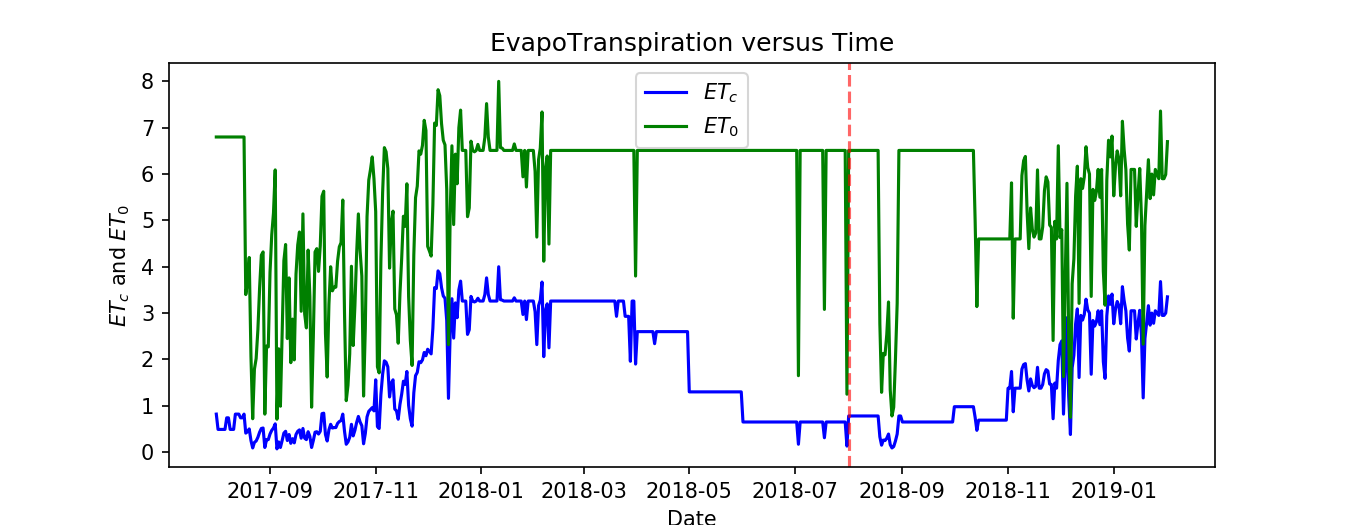

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 3.5)

ax.plot(df_et.index, df_et["etc"], color="blue", label="$ET_c$")
ax.plot(df_et.index, df_et["et0"], color="green", label="$ET_0$")
ax.legend(loc=0)
ax.axvline(x=datetime.datetime(2018, 8, 1), linestyle="--", color="red", alpha=0.6)
ax.set_ylabel("$ET_c$ and $ET_0$")
ax.set_xlabel("Date")
ax.set_title("EvapoTranspiration versus Time")
plt.show()

<IPython.core.display.Javascript object>


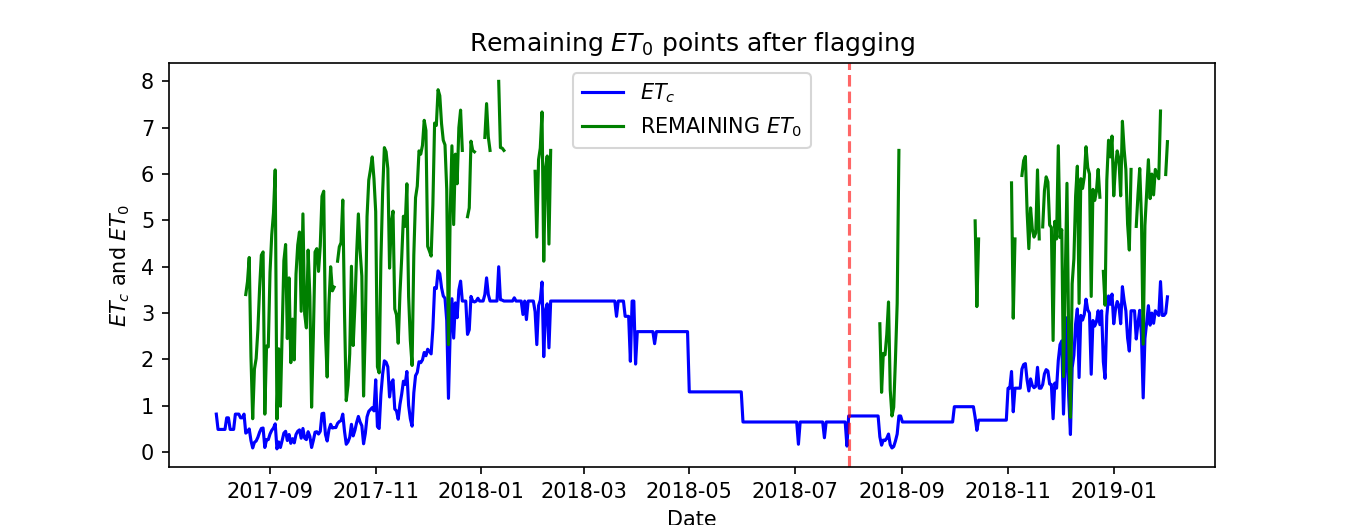

In [38]:
df_et.loc[bad_et0_days, ["et0"]] = np.nan

fig, ax = plt.subplots()
fig.set_size_inches(9, 3.5)

ax.plot(df_et.index, df_et["etc"], color="blue", label="$ET_c$")
ax.plot(df_et.index, df_et["et0"], color="green", label="REMAINING $ET_0$")
ax.legend(loc=0)
ax.axvline(x=datetime.datetime(2018, 8, 1), linestyle="--", color="red", alpha=0.6)
ax.set_ylabel("$ET_c$ and $ET_0$")
ax.set_xlabel("Date")
ax.set_title("Remaining $ET_0$ points after flagging")
plt.show()

In [39]:
et0_max = max(df_et["et0"])
print("The maximum et0 is equal to: {:.2f}.".format(et0_max))

The maximum et0 is equal to: 8.00.


# `"etcp"` versus time

Notice that `"etcp"` belongs to column J in the Excel file.  
`"etcp"` is defined as the difference between consecutive `"profile"` readings.

We are only interested in the $ET_{cp}$ entries for which $ET_{cp} \le 0$.  These negative entries reflect incidents in which water was most likely taken up by the plant and lost through evapotranspiration.  

We are not interested in dates in which $ET_{cp}$ is perturbed by irrigation and/or rain.  For such dates where $ET_{cp}$ is perturbed, we expect $ET_{cp} \ge 0$.

In [40]:
condition = df_et["etcp"] >= 0.0
bad_etcp_days = df_et[condition].index

flagger(bad_dates=bad_etcp_days, brief_desc="etcp is positive")

In [41]:
calc = 100 - df_flag["binary_value"].sum()/len(data.index)*100
print("At this point, only {:.0f}% of your data is useful.".format(calc))

n_lost = len(bad_etcp_days)
print("We have lost {:.1f}% of data.".format(n_lost/len(data.index)*100))

At this point, only 0% of your data is useful.
We have lost 36.9% of data.


Let us set the $ET_{cp}$ values for which _all_ the associated dates in the `df_flag` DataFrame is flagged to `np.nan`.

In [42]:
condition = df_flag["binary_value"] == 1
flagged_dates = df_flag[condition].index

df_et.loc[flagged_dates, "etcp"] = np.nan
df_et.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 5 columns):
etc          550 non-null float64
et0          254 non-null float64
etcp         0 non-null float64
et0_diff1    549 non-null float64
et0_diff2    548 non-null float64
dtypes: float64(5)
memory usage: 45.8 KB


In [43]:
df_et.describe()

,etc,et0,etcp,et0_diff1,et0_diff2
count,550.000000,254.000000,0.0,549.000000,548.000000
mean,1.637545,4.649764,NaN,-0.000182,-0.001661
std,1.141910,1.755063,NaN,1.093288,1.349620
min,0.070000,0.710000,NaN,-5.380000,-5.260000
25%,0.650000,3.360000,NaN,0.000000,0.000000
50%,1.300000,4.895000,NaN,0.000000,0.000000
75%,2.890000,6.100000,NaN,0.090000,0.082500
max,4.000000,8.000000,NaN,5.260000,5.260000


In the cell below, we multiply all the (negative) $ET_{cp}$ values by -1 so that henceforth we only work with positive values of $ET_{cp}$ (which in my opinion is a little bit more convenient).

In [44]:
df_et["etcp"] = df_et["etcp"].multiply(-1)
df_et.describe()

,etc,et0,etcp,et0_diff1,et0_diff2
count,550.000000,254.000000,0.0,549.000000,548.000000
mean,1.637545,4.649764,NaN,-0.000182,-0.001661
std,1.141910,1.755063,NaN,1.093288,1.349620
min,0.070000,0.710000,NaN,-5.380000,-5.260000
25%,0.650000,3.360000,NaN,0.000000,0.000000
50%,1.300000,4.895000,NaN,0.000000,0.000000
75%,2.890000,6.100000,NaN,0.090000,0.082500
max,4.000000,8.000000,NaN,5.260000,5.260000


<IPython.core.display.Javascript object>


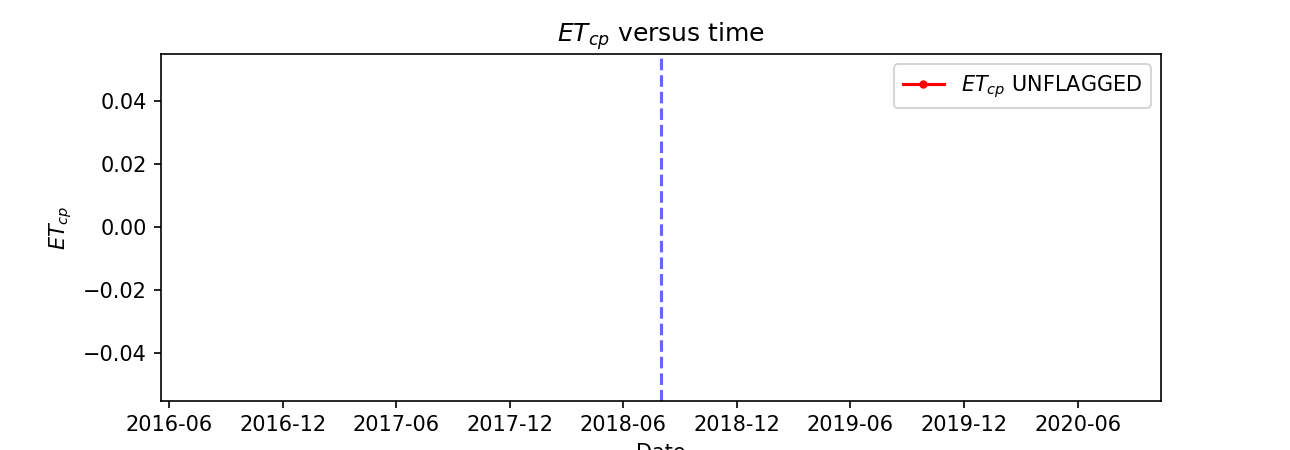

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(8.6, 3)

ax.plot(df_et.index, df_et["etcp"], color="red", label="$ET_{cp}$ UNFLAGGED", 
        marker="o", ms=3, mfc="red", mec="red", mew=1)
ax.set_xlabel("Date")
ax.set_ylabel("$ET_{cp}$")
ax.set_title("$ET_{cp}$ versus time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", alpha=0.6, ls="--")
ax.legend()
plt.show()

# Remove $ET_{cp}$ outliers

The `"etcp"` column needs some flagging; we want to get rid of the outliers.

In [46]:
s = df_et["etcp"].quantile([0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.91, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
s

0.50   NaN
0.60   NaN
0.70   NaN
0.75   NaN
0.80   NaN
0.85   NaN
0.90   NaN
0.91   NaN
0.92   NaN
0.94   NaN
0.95   NaN
0.96   NaN
0.97   NaN
0.98   NaN
0.99   NaN
1.00   NaN
Name: etcp, dtype: float64

Let us accept that the maximum value for $ET_0$ is approximately 12.0.  Remember also that from our "Evapotranspiration vs Time" graph, our maximum value for $ET_0$ was 8.00.  
Let us be "generous" and allow for a maximum $k_{cp}$ of 0.8 (the exact value allowed here is of course debatable).  
This implies that the maximum allowed value for $ET_{cp}$ is as follows:

$$
\mathrm{max}(ET_{cp}) = 0.8 \times 12 = 9.6 \approx 10
$$

Let us perform another filtering process to get rid of all $ET_{cp}$ values higher than 10.

In [47]:
condition = df_et["etcp"] >= 10
bad_high_etcp_dates = df_et[condition].index

flagger(bad_dates=bad_high_etcp_dates, brief_desc="etcp outliers")

You have already flagged these dates for the reason given in `brief_desc`; No flagging has taken place.


In [48]:
calc = 100 - df_flag["binary_value"].sum()/len(data.index)*100
print("At this point, only {:.0f}% of your data is useful.".format(calc))

n_lost = len(bad_high_etcp_dates)
print("We have lost {:.1f}% of data.".format(n_lost/len(data.index)*100))

At this point, only 0% of your data is useful.
We have lost 0.0% of data.


# Remove dates for which luxurious water uptake is present

For days in which there is luxurious water uptake, we expect that $ET_{cp} > 0.8 ET_{0}$.  We need to filter such dates.

In [49]:
condition = df_et["etcp"] > df_et["et0"].mul(0.8, fill_value=np.nan)
luxurious_dates = df_et[condition].index

flagger(bad_dates=luxurious_dates, brief_desc="Luxurious water uptake")

You have already flagged these dates for the reason given in `brief_desc`; No flagging has taken place.


In [50]:
calc = 100 - df_flag["binary_value"].sum()/len(data.index)*100
print("At this point, only {:.0f}% of your data is useful.".format(calc))

n_lost = len(luxurious_dates)
print("We have lost {:.1f}% of data.".format(n_lost/len(data.index)*100))

At this point, only 0% of your data is useful.
We have lost 0.0% of data.


# Evaluate the remaining $ET_{cp}$ entries which are _hopefully_ valid data points

In [51]:
condition = df_flag["binary_value"] == 1
flagged_dates = df_flag[condition].index

df_et.loc[flagged_dates, ["etcp"]] = np.nan
df_et.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 5 columns):
etc          550 non-null float64
et0          254 non-null float64
etcp         0 non-null float64
et0_diff1    549 non-null float64
et0_diff2    548 non-null float64
dtypes: float64(5)
memory usage: 45.8 KB


<IPython.core.display.Javascript object>


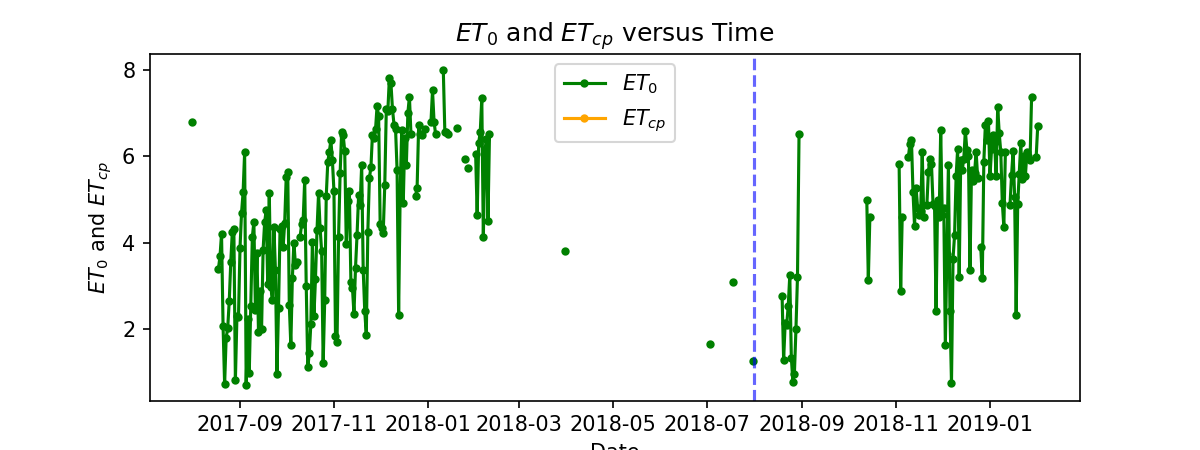

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

condition = df_et["etcp"].notnull()
etcp_index = condition.index

ax.plot(df_et.loc[etcp_index, ["et0"]], color="green", label="$ET_0$", 
        marker="o", ms=3, mfc="green", mec="green", mew=1)
ax.plot(df_et.loc[etcp_index, ["etcp"]], color="orange", label="$ET_{cp}$", 
        marker="o", ms=3, mfc="orange", mec="orange", mew=1)
ax.set_xlabel("Date")
ax.set_ylabel("$ET_0$ and $ET_{cp}$")
ax.set_title("$ET_0$ and $ET_{cp}$ versus Time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", alpha=0.6, ls="--")
ax.legend()
plt.show()

# Rough calculation of $k_{cp}$

<IPython.core.display.Javascript object>


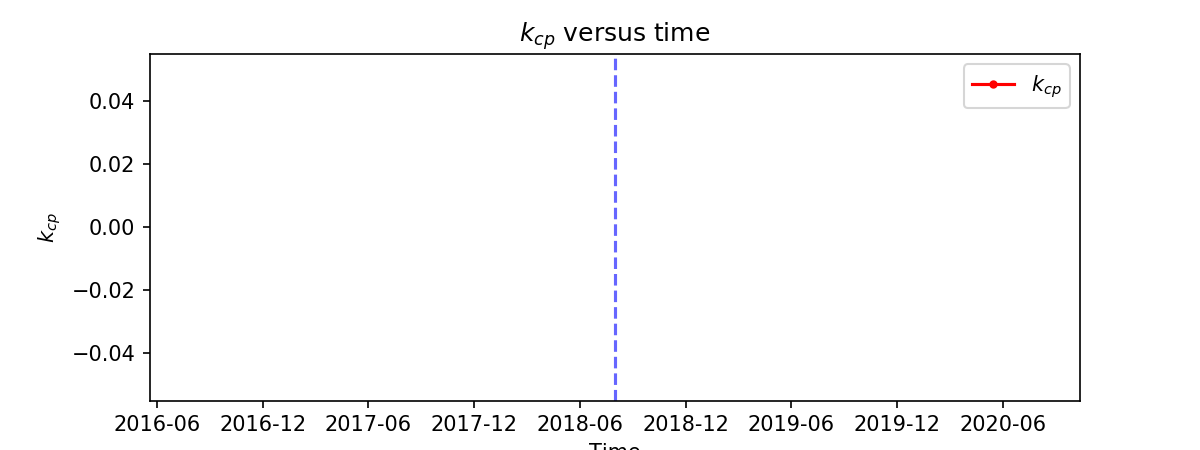

In [53]:
df_et["kcp"] = df_et["etcp"].div(df_et["et0"], fill_value=np.nan)

fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.plot(df_et.index, df_et["kcp"], color="red", label="$k_{cp}$",
        marker="o", ms=3, mfc="red", mec="red", mew=1)
ax.set_xlabel("Time")
ax.set_ylabel("$k_{cp}$")
ax.set_title("$k_{cp}$ versus time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", alpha=0.6, ls="--")
ax.legend()
plt.show()

# Merge the original `data` DataFrame with the `df_flag` DataFrame

In [54]:
master_data = pd.concat([data, df_flag], axis=1, join="inner")
master_data.head(n = 100)

,heat_units,rain,erain,total_irrig,tot_eff_irrig,etc,ety,et0,etcp,rzm_source,profile,original_unit_system,binary_value,description
date,,,,,,,,,,,,,,
2017-08-01,0.000000,0.0,0.0,0.0,0.00,0.82,0.68,6.80,120.37,Electronic Probe,120.37,si,1,Irrigation perturbing etcp. etcp is positive.
2017-08-02,0.000000,1.0,0.0,0.0,0.00,0.49,0.68,6.80,1.32,Electronic Probe,121.69,si,1,Irrigation perturbing etcp. Heat Units `stuck`...
2017-08-03,0.000000,0.2,0.0,0.0,0.00,0.49,0.68,6.80,0.50,Electronic Probe,122.19,si,1,Irrigation perturbing etcp. Heat Units `stuck`...
2017-08-04,0.000000,0.0,0.0,0.0,0.00,0.49,0.68,6.80,0.71,Electronic Probe,122.91,si,1,Irrigation perturbing etcp. Heat Units `stuck`...
2017-08-05,0.000000,0.0,0.0,0.0,0.00,0.49,0.68,6.80,0.10,Electronic Probe,123.01,si,1,Irrigation perturbing etcp. Heat Units `stuck`...
2017-08-06,0.000000,0.0,0.0,0.0,0.00,0.49,0.68,6.80,0.86,Electronic Probe,123.87,si,1,Irrigation perturbing etcp. Heat Units `stuck`...
2017-08-07,0.800000,0.0,0.0,0.0,0.00,0.74,0.68,6.80,-0.28,Electronic Probe,123.59,si,1,Irrigation perturbing etcp. et0 `stuck`.
2017-08-08,2.750000,0.0,0.0,0.0,0.00,0.74,0.68,6.80,-0.19,Electronic Probe,123.40,si,1,Irrigation perturbing etcp. et0 `stuck`.
2017-08-09,1.250000,0.0,0.0,0.0,0.00,0.49,0.19,6.80,-0.10,Electronic Probe,123.30,si,1,Irrigation perturbing etcp. et0 `stuck`.


In [55]:
master_data.count()

heat_units              550
rain                    550
erain                   550
total_irrig             550
tot_eff_irrig           550
etc                     550
ety                     550
et0                     550
etcp                    550
rzm_source              550
profile                 550
original_unit_system    550
binary_value            550
description             550
dtype: int64